# Lab  - Investigating the Performance Advantages of NumPy Arrays

At a high level, the purpose of this lab is to test how much more efficient bulk, vectorized operations can by (using NumPy arrays) than standard, dictionary-oriented Python computations.

In this lab, your task is to compare three different solutions to the co-occurrence problem. This is a very fundamental computation in text analytics. 

In a nutshell:
  * we have **n** documents
  * each document is represented as a map from "wordId" to "# of times it appears in the document"
    * `{0: 10, 1: 2, ..., 19: 5}` indicates a document where word 0 appears 10 times, 
      word 1 two times, and word 19 five times.
    * if a "wordId" is **not present** in a document dictionary, treat it as a count of 0
    * in subtask 2 & 3, this "map" is a numpy array in which the index is the wordId
  * the corpus is represented as a map from "docId" to "document"
    * in subtask 2 & 3, this "map" is a numpy array in which the index is the docId.

For each of the possible (word, word) pairs, we want to compute the number of documents (i.e. value must be between zero and  **n**) that have that particular (word, word) pair. That is, compute the co-occurrence of each possible word pair in the corpus of documents.

For example, let’s say our documents are:
```
doc 1: [word1, word2, word4, word5]
doc 2: [word1, word2, word5]
doc 3: [word2, word3, word5]
```
Then the result of the co-occurrence computation is:
```
{word1, word1}: 2 co-occurs (meaning that word1 occurs in two documents in the corpus)
{word1, word2}: 2 co-occurs
{word1, word4}: 1 co-occurs
{word1, word5}: 2 co-occurs
{word2, word2}: 3 co-occurs
{word2, word3}: 1 co-occurs
{word2, word4}: 1 co-occurs
{word2, word5}: 3 co-occurs
{word3, word3}: 1 co-occurs
{word3, word5}: 1 co-occurs
{word4, word4}: 1 co-occurs
{word4, word5}: 1 co-occurs
{word5, word5}: 3 co-occurs
```


## Subtask One
First, take a look at the following code. It is a pure, dictionary-based implementation provided to build a document corpus. This will build the `wordsInCorpus` object, which is a Python dictionary. The dictionary’s key is a document identifier, and the value is another dictionary. For the dictionary associated with a particular document identifier, the key is a word identifier, and the value is the number of occurrences of the word in the document. Visually:

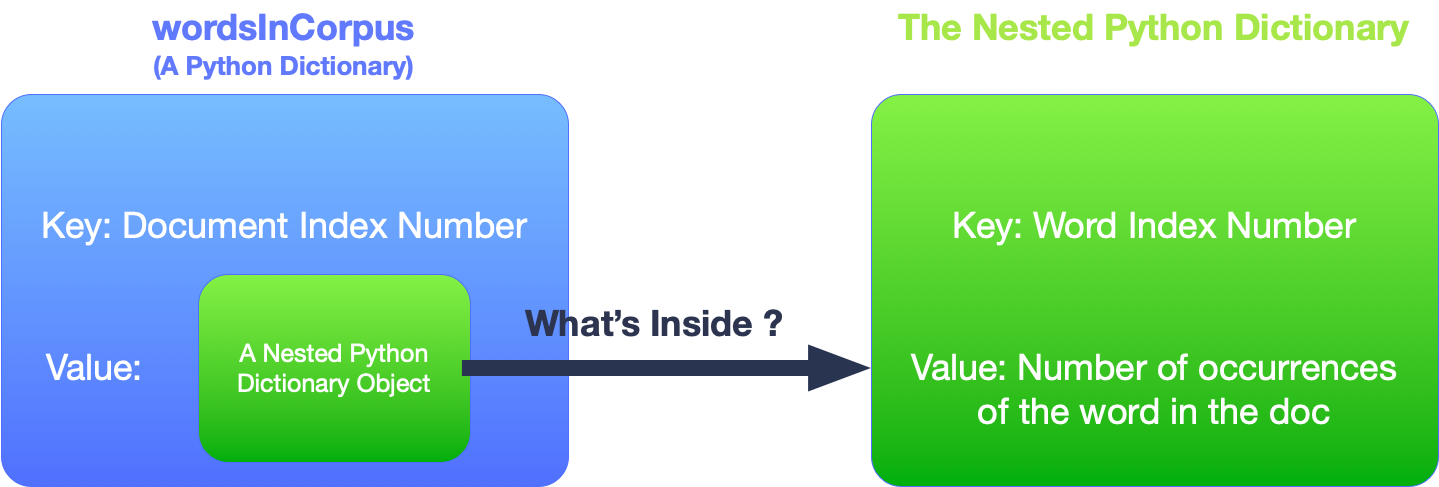

In [2]:
import numpy as np
import time;

# uncomment the next line to produce the same results every time
np.random.seed(553)

# this returns a number whose probability of occurence is p
def sampleValue (p):
    return np.flatnonzero (np.random.multinomial (1, p, 1))[0]
 
# there are 2000 words in the corpus
alpha = np.full (2000, .1)
 
# there are 100 topics
beta = np.full (100, .1)
 
# this gets us the probabilty of each word happening in each of the 100 topics
wordsInTopic = np.random.dirichlet (alpha, 100)
# wordsInCorpus[i] will be a dictionary that gives us the number of each word in the document
wordsInCorpus = {}
 
# generate each doc
for doc in range (0, 50):
    #
    # no words in this doc yet
    wordsInDoc = {}
    #
    # get the topic probabilities for this doc
    topicsInDoc = np.random.dirichlet (beta)
    #
    # generate each of the 2000 words in this document
    for word in range (0, 2000):
        #
        # select the topci and the word
        whichTopic = sampleValue (topicsInDoc)
        whichWord = sampleValue (wordsInTopic[whichTopic])
        #
        # and record the word
        wordsInDoc [whichWord] = wordsInDoc.get (whichWord, 0) + 1
        #
    # now, remember this document
    wordsInCorpus [doc] = wordsInDoc

### Consider

#### What have you got? A dictionary of dictionaries
* The outer dictionary represents a document
* The inner dictionary is a dictionary of wordId: wordId counts


#### What do you need?
* A dictionary with keys (word1, word2) pairs
* and values of the total number of documents in which (word1, word2) occurs

During lab we will write code to compute the total number of documents that contain each co-occurrence.

## Subtask Two
Review the NumPy array-based implementation in the next cell. This code will build the ```wordsInCorpus``` array. 

It stores the same kind of data as Subtask 1, but in a NumPy array, where each row represents a document and each column represents a word. 
```
wordsInCorpus[34, 355] 
```
is the number of times that word 355 in the dictionary occurred in document 34.

During lab, we will write code that uses this representation to compute the total number of documents that contain each co-occurrence.

### array-based approach


In [1]:
import numpy as np
import time

# uncomment the next line to produce the same results every time
np.random.seed(553)

# there are 2000 words in the corpus
alpha = np.full (2000, .1)
 
# there are 100 topics
beta = np.full (100, .1)
 
# this gets us the probabilty of each word happening in each of the 100 topics
wordsInTopic = np.random.dirichlet (alpha, 100)
 
# wordsInCorpus[i] will give us the vector of words in document i
wordsInCorpus = np.zeros ((50, 2000))
 
# generate each doc
for doc in range (0, 50):
    #
    # get the topic probabilities for this doc
    topicsInDoc = np.random.dirichlet (beta)
    #
    # assign each of the 2000 words in this doc to a topic
    wordsToTopic = np.random.multinomial (2000, topicsInDoc)
    # 
    # and generate each of the 2000 words
    for topic in range (0, 100):
        wordsFromCurrentTopic = np.random.multinomial (wordsToTopic[topic], wordsInTopic[topic])
        wordsInCorpus[doc] = np.add (wordsInCorpus[doc], wordsFromCurrentTopic)

### outer product

Recall, the [**outer product**](https://en.wikipedia.org/wiki/Outer_product) of two column vectors $u$ and $v$, where $u \in \mathbb{R}^m$ and $v \in \mathbb{R}^n$ is defined as:

$$
\begin{bmatrix}
u_1\\
u_2\\
\vdots \\
u_m\\
\end{bmatrix}
\bigotimes
\begin{bmatrix}
v_1 & v_2 & \ldots & v_n\\
\end{bmatrix}
= uv^T =
\begin{bmatrix}
u_1v_1 & u_1v_2 & \ldots & u_1v_n\\
u_2v_1 & u_2v_2 & \ldots & u_2v_n\\
\vdots & \vdots & \ddots & \vdots \\
u_mv_1 & u_mv_2 & \ldots & u_mv_n\\
\end{bmatrix}
$$

## Subtask Three

We will use the same data representation as Subtask Two.

This time, consider the entire matrix that contains a row for each document. We will use a matrix approach to solve the co-occurrence problem.

During lab, we will write code that uses this representation to compute the total number of documents that contain each co-occurrence.

Recall, the [**product**](https://en.wikipedia.org/wiki/Matrix_multiplication) of two matrices $A$ and $B$, where $A \in \mathbb{R}^{n \times m}$ and $B \in \mathbb{R}^{m \times p}$ is a $n \times p$ dimension matrix $C$:


$$
\begin{bmatrix}
a_{1,1} & a_{1,2} & \ldots & a_{1,m} \\
a_{2,1} & a_{2,2} & \ldots & a_{2,m} \\
\vdots & \vdots & \ddots & \vdots \\
a_{n,1} & a_{n,2} & \ldots & a_{n,m} \\
\end{bmatrix}
\begin{bmatrix}
b_{1,1} & b_{1,2} & \ldots & b_{1,p} \\
b_{2,1} & b_{2,2} & \ldots & b_{2,p} \\
\vdots & \vdots & \ddots & \vdots \\
b_{m,1} & b_{m,2} & \ldots & b_{m,p} \\
\end{bmatrix}
=
\begin{bmatrix}
c_{1,1} & c_{1,2} & \ldots & c_{1,p} \\
c_{2,1} & c_{2,2} & \ldots & c_{2,p} \\
\vdots & \vdots & \ddots & \vdots \\
c_{n,1} & c_{n,2} & \ldots & c_{n,p} \\
\end{bmatrix}
$$


where each entry, $C_{ij} = \langle A_i, B_{\cdot,j} \rangle = \sum_{k=1}^m A_{i,k}B_{k,j}$. Note that $B_{\cdot,j}$ indicates the $j^{th}$ column of $B$ and $A_i$ indicates the $i^{th}$ row of $A$.

Copyright ©  2024 Rice University

Licensed under the Apache License, Version 2.0 (the "License");
you may not use this file except in compliance with the License.
You may obtain a copy of the License at

    https://www.apache.org/licenses/LICENSE-2.0

Unless required by applicable law or agreed to in writing, software
distributed under the License is distributed on an "AS IS" BASIS,
WITHOUT WARRANTIES OR CONDITIONS OF ANY KIND, either express or implied.
See the License for the specific language governing permissions and
limitations under the License.